# Implementing Convolutional Neural Networks in PyTorch

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

In [7]:
num_epochs = 6
num_classes = 10
batch_size = 100
learning_rate = 0.001

DATA_PATH = "..\MNISTData"
MODEL_STORE_PATH = "..\Model"

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:03<00:00, 2723188.50it/s]


Extracting ..\MNISTData\MNIST\raw\train-images-idx3-ubyte.gz to ..\MNISTData\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting ..\MNISTData\MNIST\raw\train-labels-idx1-ubyte.gz to ..\MNISTData\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 3808792.63it/s]


Extracting ..\MNISTData\MNIST\raw\t10k-images-idx3-ubyte.gz to ..\MNISTData\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8864834.23it/s]

Extracting ..\MNISTData\MNIST\raw\t10k-labels-idx1-ubyte.gz to ..\MNISTData\MNIST\raw



### Creating Model

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Model

In [10]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/600], Loss: 0.1024, Accuracy: 96.00%
Epoch [1/6], Step [200/600], Loss: 0.1854, Accuracy: 95.00%
Epoch [1/6], Step [300/600], Loss: 0.1139, Accuracy: 94.00%
Epoch [1/6], Step [400/600], Loss: 0.1299, Accuracy: 95.00%
Epoch [1/6], Step [500/600], Loss: 0.1458, Accuracy: 94.00%
Epoch [1/6], Step [600/600], Loss: 0.1720, Accuracy: 97.00%
Epoch [2/6], Step [100/600], Loss: 0.0578, Accuracy: 99.00%
Epoch [2/6], Step [200/600], Loss: 0.0948, Accuracy: 98.00%
Epoch [2/6], Step [300/600], Loss: 0.0529, Accuracy: 99.00%
Epoch [2/6], Step [400/600], Loss: 0.0471, Accuracy: 98.00%
Epoch [2/6], Step [500/600], Loss: 0.2589, Accuracy: 92.00%
Epoch [2/6], Step [600/600], Loss: 0.0778, Accuracy: 96.00%
Epoch [3/6], Step [100/600], Loss: 0.1091, Accuracy: 96.00%
Epoch [3/6], Step [200/600], Loss: 0.1505, Accuracy: 97.00%
Epoch [3/6], Step [300/600], Loss: 0.0148, Accuracy: 100.00%
Epoch [3/6], Step [400/600], Loss: 0.0249, Accuracy: 99.00%
Epoch [3/6], Step [500/600], Loss: 0.04

### Testing Model

In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)


Test Accuracy of the model on the 10000 test images: 99.02 %


In [12]:
show(p)

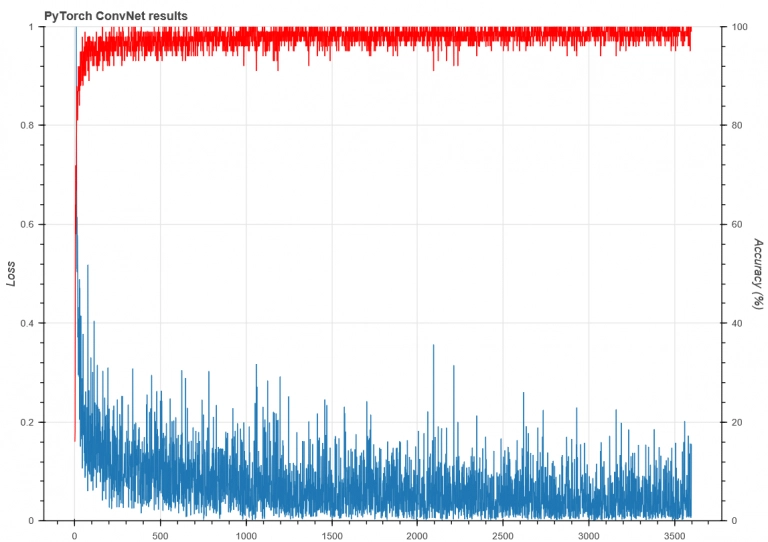